# Example Documenting db_init.py

A proposed format for documenting code

# Define Spatial Extent of Project

This notebook retrieves Metropolitan Council's 2020 boundaries of the Twin Cities area and extracts the Minneapolis's boundary.

Source: https://gisdata.mn.gov/dataset/us-mn-state-metc-bdry-census2020counties-ctus

Metadata: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_metc/bdry_census2020counties_ctus/metadata/metadata.html

In [6]:
### Import Packages

# File manipulation

import os # For working with Operating System
import shutil # For deleting folders
import urllib # For accessing websites
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects

# Database 

import psycopg2 # For working with postgresql database
from psycopg2 import sql
from App.modules.db_conn import pg_connection_dict # Custom functions that get database credentials from .env

# Analysis

import pandas as pd # Data Management
import geopandas as gpd # Spatial Data Manipulation

In [2]:
### Definitions

def extract_zip_from_url(url=None, savepath=None):
    '''Extract a zipfile from the internet
    then unpack it in to it's own folder 
    within the working directory.
    Takes a single url (string).'''

    if not os.path.exists(savepath):
        os.makedirs(savepath)
    # Unload zip into the new folder
    response = urllib.request.urlopen(url) # Get a response
    zip_folder = zipfile.ZipFile(BytesIO(response.read())) # Read Response
    zip_folder.extractall(path=savepath) # Extract files
    zip_folder.close() # Close zip object

In [3]:
# Download Data

## Twin Cities Metro Boundaries - Downloaded from MN GeospatialCommons gisdata.mn.gov  (~ 5mb)

url = "https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_metc/bdry_census2020counties_ctus/shp_bdry_census2020counties_ctus.zip"

# Create folder name for file
folder_name = 'shp_bdry_census2020counties_ctus' # url.split('/')[-1][:-4] <- programatic way to get foldernam
# Define path for downloaded files
savepath = os.path.join('..', 'Data', folder_name)

extract_zip_from_url(url, savepath)

In [4]:
# Read Data & Select Minneapolis

# Get path

filename = 'Census2020CTUs.shp'
path = os.path.join(savepath, filename)

ctus_boundaries = gpd.read_file(path)

# Select Minneapolis

mpls_boundary = ctus_boundaries[ctus_boundaries['CTU_NAME'] == 'Minneapolis']

<Axes: >

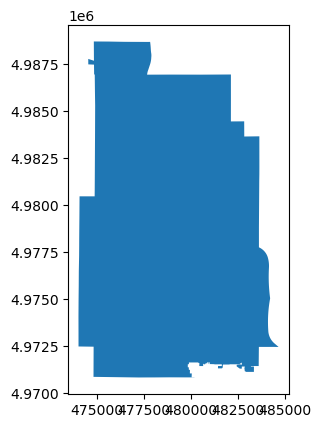

In [5]:
# Check it out visually! Notice it's in UTM 15N Coordinates, will have to change when uploading to database!

mpls_boundary.plot()

In [ ]:
# Upload to Database

conn = psycopg2.connect(**pg_connection_dict) # pg_connection_dict from db_conn

# Create Cursor for commands

cur = conn.cursor()

# Insert into table

cols = ['CTU_ID', 'CTU_NAME', 'CTU_CODE', 'geometry'] # Field/Columns in mpls_boundary Names

for i, row in mpls_boundary[cols].iterrows():

    cur.execute(
        'INSERT INTO "Minneapolis Boundary"("CTU_ID", "CTU_NAME", "CTU_CODE", geometry)'
        'VALUES (%(ctu_id)s, %(ctu_name)s, %(ctu_code)s, ST_Transform(ST_SetSRID(ST_GeomFromText(%(geom)s), 26915),4326)::geometry);',
        {'ctu_id': row[0],
         'ctu_name' : row[1],
         'ctu_code': row[2],
         'geom': row[3].wkt})

    # Commit command

    conn.commit()

# Close cursor

cur.close()

# Close connection

conn.close()